# 5 - Conversion to SLR equivalent estimates
- creates a fit of how much glacier volume below sea-level is lost vs total volume (by using OGGM data). This fit is used later in `6_csv_tables_creation.ipynb` (this needs some additional raw files from OGGM simulations).
- also creates **supplementary figure S14** to show the relationship of the ratio to the total volume (and the applied fit from the OGGM data)

In [1]:
DATE = 'Feb12_2024'

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import oggm
import geopandas as gpd
from  help_functions import d_reg_num_name_sh

In [3]:
# Define experiments 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['hist', 'ssp126', 'ssp370', 'ssp585']
y0_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

rgidf_dict = {}
for rgi_reg in rgi_regs:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')
    df_itmix.loc[rgidf.RGIId.values,'rgi_region'] = rgi_reg
# remove 05-connectivity 2 glaciers 
df_itmix = df_itmix.loc[~df_itmix.rgi_region.isna()]

path_rgi = oggm.utils.get_rgi_region_file('05', version='6')
rgidf = gpd.read_file(path_rgi)
rgidf_c = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
n_excluded = len(rgidf) - len(rgidf_c)
print(f'amount of glaciers excluded in RGI region 05 because they are connectivity level 2: {n_excluded}')

amount of glaciers excluded in RGI region 05 because they are connectivity level 2: 955


In [4]:
def get_path_asl(folder_path='/home/www/lschuster/glacierMIP3_analysis',
             rgi_reg='01',
             model_author='OGGM_v16',
             period='1851-1870', gcm='gfdl-esm4', ssp='hist'):
    ''' output the regional simulation file path for the respective
    rgi_reg, model_author, period, gcm & ssp '''
    if ('OGGM' in model_author):
        # was corrected for missing glaciers ... (by Lilian Schuster with method of Fabien)
        model_author_f = model_author
        if 'OGGM' in model_author and ssp == 'hist':
            ssp = 'historical'
            path =  f'{folder_path}/{model_author_f}/regional_filled_asl/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
        else:
            path =  f'{folder_path}/{model_author_f}/regional_filled_asl/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
    else:
        print('Not implemented...')
    return path
#path = get_path(rgi_reg=rgi_reg, model_author='OGGM_v153', period=period, gcm='gfdl-esm4', ssp=scenario)
#path = get_path(rgi_reg=rgi_reg, model_author='OGGM_v16', period=period, gcm=gcm, ssp=scenario)
#xr.open_dataset(path)

In [5]:
# converge the below sea level and total volume estimates into one netcdf file ... 
model_authors = ['OGGM_v16'] 

# We need dummy datasets, because some files only go until 2000 and have to be extended then in order to be merged with the other files 
# dummy dataset ... w. 5001 entries
ds_nan_5001 = xr.open_dataset(get_path_asl(rgi_reg='01'))
ds_nan_5001.volume_m3.data[...] = np.NaN
ds_nan_5001.volume_bsl_m3.data[...] = np.NaN

# dummy dataset ... w. 2001 entries
ds_nan_2001 = xr.open_dataset(get_path_asl(rgi_reg='02')) 
ds_nan_2001.volume_m3.data[...] = np.NaN
ds_nan_2001.volume_bsl_m3.data[...] = np.NaN


# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']


### this takes some time ... 
run = False 
if run:
    for apply_scaling in [False]:
        l_ds_list = []
        for model_author in model_authors: #['OGGM_v153']: #model_authors:
            print(model_author)
            missing_exp=[]
            _ds_reg = []
            for rgi_reg in rgi_regs: #'01'
                # want to have the right simulation year length
                _l_period = []
                for y0_time in y0_times[:4]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[:1]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path_asl(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.volume_bsl_m3.data[:-1] = _ds.volume_bsl_m3.squeeze()
                                    # we will just fill up the last value with the second to the last value
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.volume_bsl_m3[-1] = ds.volume_bsl_m3[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                # in case of OGGM 11, went for 5000 yrs anyways
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.volume_bsl_m3.data = ds.volume_bsl_m3.squeeze()*1e6 # is in km3 instead of m3

                            ds = ds.reset_coords()[['volume_m3', 'volume_bsl_m3']]
                            #if apply_scaling:
                            #    ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))

                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_past = xr.concat(_l_period, dim='period')

                _l_period = []
                for y0_time in y0_times[4:]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[1:]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path_asl(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                #if model_author == 'Compagno' and gcm=='ukesm1-0-ll' and rgi_reg == '05':
                                #    raise ValueError('duplicate values, fill with np.NaN')
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.volume_bsl_m3.data[:-1] = _ds.volume_bsl_m3.squeeze()
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.volume_bsl_m3[-1] = ds.volume_bsl_m3[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.volume_bsl_m3.data = ds.volume_bsl_m3.squeeze()*1e6 # is in km3 instead of m3
                            ds = ds.reset_coords()[['volume_m3', 'volume_bsl_m3']]
                            #if apply_scaling:
                            #    ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))
                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_future = xr.concat(_l_period, dim='period')
                _ds_reg_single = xr.concat([ds_past, ds_future], dim = 'ssp')
                # make sure that simulation_year is a coordinate
                _ds_reg_single.coords['simulation_year'] = _ds_reg_single.simulation_year
                _ds_reg.append(_ds_reg_single)
            ds = xr.concat(_ds_reg, dim='rgi_reg')

            _ds_mod = ds.expand_dims({'model_author':[model_author]})
            l_ds_list.append(_ds_mod)

        ds_reg_models = xr.concat(l_ds_list, dim='model_author')

        # This is the same for all files
        encoding = {
            'simulation_year': {"dtype": "int16"},
            'volume_m3': {"dtype": "float32"},
            'volume_bsl_m3': {"dtype": "float32"},
        }

        ds_reg_models = ds_reg_models.stack(period_scenario = ('period', 'ssp'))
        ds_reg_models.coords['period_scenario'] = [a[0]+'_'+a[1] for a in ds_reg_models.period_scenario.values]

        l_period_ssp = ['1851-1870_hist', '1901-1920_hist', '1951-1970_hist',
           '1995-2014_hist',  '2021-2040_ssp126',
           '2021-2040_ssp370', '2021-2040_ssp585', 
           '2041-2060_ssp126', '2041-2060_ssp370', '2041-2060_ssp585',
           '2061-2080_ssp126', '2061-2080_ssp370',
           '2061-2080_ssp585', '2081-2100_ssp126',
           '2081-2100_ssp370', '2081-2100_ssp585']

        ds_reg_models = ds_reg_models.sel(period_scenario = l_period_ssp)

        out_path =f'../0_pre_post_processing/_intermediate_data/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum.nc'
        # put NaN into the duplicated file 
        ds_reg_models.attrs = {} # this needs to be filled with some informations, but for know leave it empty 
        ds_reg_models.to_netcdf(out_path, encoding = encoding)
else:
    out_path = out_path =f'../0_pre_post_processing/_intermediate_data/glacierMIP3_only_oggm_v16_volume_bsl_{DATE}_all_rgi_regions_sum.nc'
    ds_reg_models = xr.open_dataset(out_path)

In [6]:
run = False
if run: 
    import pymannkendall as mk

    # these regions should run until 5000 years:
    rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        

    for fill_option in ['repeat_last_101yrs']: #'repeat_last_21yrs',
        n_increasing = 0
        n_decreasing = 0
        n_no_trend = 0
        deltaV_l = []
        deltaV_l50 = []
        ds_reg_models_extend = ds_reg_models.copy()
        for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
            for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
                for m in np.arange(0, len(ds_reg_models_extend.model_author),1):

                    ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
                    #print(ds)
                    for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                        if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_bsl_m3.values)):
                            # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                            pass
                        #elif rgi_reg in rgi_regs_5000:
                        #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        else:
                            # check that all are not nan-values! -> then do not need to extend
                            if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                                pass
                            else:
                                #try:
                                # check that it is really always np.NaN values after simulation year 2000 for that region
                                assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                                # Huss has area 0 for some regions 
                                assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_bsl_m3.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                                # fill them up with the last simulation year values 
                                # we fill that up that later 
                                #for y in np.arange(2001,5001):
                                if fill_option == 'last_value':
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_bsl_m3.values
                                elif fill_option == 'repeat_last_21yrs':  # 21-yr period is repeated ~142.9 times to fill up the additional 3000yrs
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).volume_m3.values, 143)[:3000]
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).volume_bsl_m3.values, 143)[:3000]
                                elif fill_option == 'repeat_last_101yrs':  # 101-yr period is repeated ~29.7 times to fill up the additional 3000yrs
                                    ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3.values, 30)[:3000]
                                    ds['volume_bsl_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_bsl_m3.values, 30)[:3000]
                                #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                                #except:
                                #    # ok some models did run over all regions for 5000 years
                                #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                                #    pass

                                dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,2000)).volume_m3
                                dendm = dend.mean(dim='simulation_year')
                                dendm_e = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1801,1900)).volume_m3.mean(dim='simulation_year')
                                deltaV_l.append((dendm.values-dendm_e.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))
                                mk_output = mk.original_test(dend, alpha=0.01)
                                if mk_output.trend =='no trend':
                                    n_no_trend +=1
                                elif mk_output.trend =='decreasing':
                                    n_decreasing +=1
                                elif mk_output.trend =='increasing':
                                    n_increasing +=1
                                #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                                dend50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1951,2000)).volume_m3
                                dendm50 = dend50.mean(dim='simulation_year')
                                dendm_e50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,1950)).volume_m3.mean(dim='simulation_year')
                                deltaV_l50.append((dendm50.values-dendm_e50.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))

                    assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
                    # add it to the big file 
                    ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
                    ds_reg_models_extend['volume_bsl_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_bsl_m3'].values

        ds_reg_models_extend.coords['extend_option'] = fill_option

        # OGGM_v16 gave global estimates -> after extending the timeseries, there should be no NaN values left 
        assert not np.any(np.isnan(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').values))

        if fill_option == 'repeat_last_21yrs': 
            # check if values are all equal to the last 20 yr timeseries for a RGI region where there are no 
            for j in np.arange(0,3000,21):
                np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1980,2000)).isel(gcm=0).isel(period_scenario=0),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2021+j)).isel(gcm=0).isel(period_scenario=0))

        if fill_option == 'repeat_last_101yrs':
            print(fill_option)
             # check if values are all equal to the last 101 yr timeseries for a RGI region where there are no 
            for j in np.arange(0,2902,101):
                np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2101+j)).isel(gcm=0).isel(period_scenario=0),
                                           rtol=1e-3)

            np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                           ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(4900,5000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                         rtol=1e-3 )

    assert np.all(np.isnan(ds_reg_models_extend.volume_m3.values) == False)
    ds_reg_models_extend_ss = ds_reg_models_extend.sel(simulation_year=slice(4900,5000)).mean(dim='simulation_year')
    ds_reg_models_extend_ss['volume_asl_m3'] = ds_reg_models_extend_ss.volume_m3 - ds_reg_models_extend_ss.volume_bsl_m3
    ds_reg_models_extend_ss_global = ds_reg_models_extend_ss.sum(dim='rgi_reg')
    ds_reg_models_extend_ss_global['ratio_vol_asl_total'] = ds_reg_models_extend_ss_global['volume_asl_m3']/ds_reg_models_extend_ss_global['volume_m3']
    pd_oggm_v16_asl_bsl_global_ss = ds_reg_models_extend_ss_global.squeeze().to_dataframe().reset_index()
    pd_oggm_v16_asl_bsl_global_ss.to_csv('../0_pre_post_processing/_intermediate_data/oggm_v16_above_vs_total_sea_level_steady_state.csv')
    
pd_oggm_v16_asl_bsl_global_ss = pd.read_csv('../0_pre_post_processing/_intermediate_data/oggm_v16_above_vs_total_sea_level_steady_state.csv', index_col=[0])

### at the moment just a small test ... 

In [7]:
pd_vol = pd.read_csv('../data/rgi_vs_2020_volume_hugonnet_estimatesFeb12_2024.csv', index_col=[0])
pd_vol = pd_vol.set_index('region')
pd_vol_glob_2020_m3 = pd_vol.loc['Globally'][f'regional_volume_m3_2020_via_5yravg']

**let's first load the Farinotti et al., 2019, below sea-level estimates**

In [8]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []

    for rgi_reg in rgi_regs_bsl:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                repeat_yrs = len(dst.time)
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
            print(gcm, rgi_reg)
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])) 
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg.to_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates.csv')
else:
    pd_slr_oggm_reg = pd.read_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates.csv', index_col=[0])
    

In [10]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []
    year_l = []

    for rgi_reg in rgi_regs:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].isel(time=slice(-101,-1)).mean(dim='time').sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = 1 #, len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                    year_l.append(5000)

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].isel(time=slice(-101,-1)).mean(dim='time').sum(dim='rgi_id')
                repeat_yrs = 1 #len(dst.time)
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                year_l.append(5000)

            print(gcm, rgi_reg)
    #volume_bsl_l_t_a = np.array(volume_bsl_l_t).flatten()
    #volume_l_t_a = np.array(volume_l_t).flatten()
    #year_l_l_a = np.concatenate(year_l)
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])
                                             #, ssp_l, per_l, gcm_l]),
                                  ) #columns = ['volume_km3','volume_km3_bsl','ssp','period','gcm'])]
    pd_slr_oggm_reg = pd_slr_oggm_reg.T
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg['year'] = '4000-5000 avg' # year_l_l_a
    pd_slr_oggm_reg.to_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates_all_regs_steady_state.csv')
else:
    pd_slr_oggm_all_reg_ss = pd.read_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates_all_regs_steady_state.csv',
                                         index_col=[0])
pd_slr_oggm_all_reg_ss_global = pd_slr_oggm_all_reg_ss.groupby(['gcm','ssp','period']).sum().reset_index()
# all experiments?
assert len(pd_slr_oggm_all_reg_ss_global) == 80
# all regions
assert np.all(pd_slr_oggm_all_reg_ss_global['rgi_reg'] == np.arange(1,20,1).sum())
# unfilled vs filled option relatively similar .. 
np.testing.assert_allclose(pd_slr_oggm_all_reg_ss_global['volume_km3'].max()*1e9, ## unfilled option ... 
pd_oggm_v16_asl_bsl_global_ss['volume_m3'].max(), rtol=2e-2) ## filled option

def convert_rel_ice_2020_mm_slr(perc, frac = 0.85):
    #need to compute the volume at steady-state 
    vol_ss = perc/100 * pd_vol_glob_2020_m3
    # then compute volume difference  in m3
    vol_diff = pd_vol_glob_2020_m3 - vol_ss
    # above sea-level
    vol_asl_diff = frac* vol_diff
    # convert m3 into sea-level equivalent 
    #A_ocean = 3.625 * 10^8
    A_ocean = 3.625 * 10**8 * 1e6 #km2 -> m2 -> 1e6
    m_slr = (vol_asl_diff/A_ocean) *900/1028 # rhoice/rho_ocean
    mm_slr = m_slr * 1000
    return mm_slr

pd_lowess_vol_gmt = pd.read_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv', index_col=[0])
pd_lowess_vol_gmt.index = pd_lowess_vol_gmt.temp_ch.round(2)
pd_lowess_vol_gmt_glob = pd_lowess_vol_gmt.loc[pd_lowess_vol_gmt.region == 'All']
(convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5']) - convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[1.5]['0.5']))/15

6.341297217267051

In [13]:
import matplotlib.pyplot as plt
run = False
if run:
    # use fit over all years as well
    volume_l_t = []
    volume_bsl_l_t = []
    gcm_l = []
    per_l = []
    ssp_l = []
    rgi_reg_l = []
    year_l = []

    for rgi_reg in rgi_regs:
        gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
        periods_f = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
        for gcm in gcms: 
            for ssp in ['ssp126','ssp370','ssp585']: 
                for period in periods_f:
                    with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                        dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                    #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                    volume_l_t.append((dst.volume/1e9).values.flatten())
                    volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                    repeat_yrs = len(dst.time)
                    ssp_l.append(np.repeat(ssp,repeat_yrs))
                    per_l.append(np.repeat(period,repeat_yrs))
                    gcm_l.append(np.repeat(gcm,repeat_yrs))
                    rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                    year_l.append(np.arange(0, len(dst.time),1))

            ssp = 'historical'
            periods_h = ['1851-1870', '1901-1920', '1951-1970', '1995-2014']
            for period in periods_h:
                with xr.open_dataset(f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/RGI{rgi_reg}/{gcm}_{ssp}_{period}.nc') as ds:
                    dst = ds[['volume','volume_bsl']].sum(dim='rgi_id')
                repeat_yrs = len(dst.time)
                #plt.plot(dst.volume/1e9, dst.volume_bsl/1e9, 'o', color='k')
                volume_l_t.append((dst.volume/1e9).values.flatten())
                volume_bsl_l_t.append((dst.volume_bsl/1e9).values.flatten())
                ssp_l.append(np.repeat(ssp,repeat_yrs))
                per_l.append(np.repeat(period,repeat_yrs))
                gcm_l.append(np.repeat(gcm,repeat_yrs))
                rgi_reg_l.append(np.repeat(rgi_reg,repeat_yrs))
                year_l.append(np.arange(0, len(dst.time),1))

            print(gcm, rgi_reg)
    #volume_bsl_l_t_a = np.array(volume_bsl_l_t).flatten()
    #volume_l_t_a = np.array(volume_l_t).flatten()
    year_l_l_a = np.concatenate(year_l)
    volume_l_t_a = np.concatenate(volume_l_t)
    volume_bsl_l_t_a = np.concatenate(volume_bsl_l_t)

    pd_slr_oggm_reg  =pd.DataFrame(np.array([volume_l_t_a, volume_bsl_l_t_a])
                                             #, ssp_l, per_l, gcm_l]),
                                  ) #columns = ['volume_km3','volume_km3_bsl','ssp','period','gcm'])]
    pd_slr_oggm_reg = pd_slr_oggm_reg.T
    pd_slr_oggm_reg = pd_slr_oggm_reg.rename(columns={0:'volume_km3', 1:'volume_km3_bsl'})
    pd_slr_oggm_reg['gcm'] = np.concatenate(gcm_l)
    pd_slr_oggm_reg['ssp'] = np.concatenate(ssp_l)
    pd_slr_oggm_reg['period'] = np.concatenate(per_l)
    pd_slr_oggm_reg['rgi_reg'] = np.concatenate(rgi_reg_l)
    pd_slr_oggm_reg['year'] = year_l_l_a
    pd_slr_oggm_reg.to_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates_all_regs.csv')
else:
    pd_slr_oggm_all_reg = pd.read_csv('../0_pre_post_processing/_intermediate_data/oggm_sea-level_estimates_all_regs.csv', index_col=[0])
    

In [14]:
pd_slr_oggm_all_global = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum()
assert np.all((pd_slr_oggm_all_global.rgi_reg == 190).values)
pd_slr_oggm_all_global

pd_slr_oggm_all_global = pd_slr_oggm_all_global.reset_index()
pd_slr_oggm_all_global_ss = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year>=1900].groupby(['gcm','period','ssp']).mean()

# don't take the first 100 years 
pd_slr_oggm_all_global = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year>=50] #.groupby(['gcm','period','ssp']).mean()


**simpler plot for supplements**

19 0.15193551735944366
LinregressResult(slope=-7.622083219875667e-07, intercept=0.9540695779131954, rvalue=-0.8585714109349116, pvalue=2.4420306947314628e-24, stderr=5.153570154357327e-08, intercept_stderr=0.003907103833654578)
0.9383500925992415
0.8911916366573802
19 0.15193551735944366


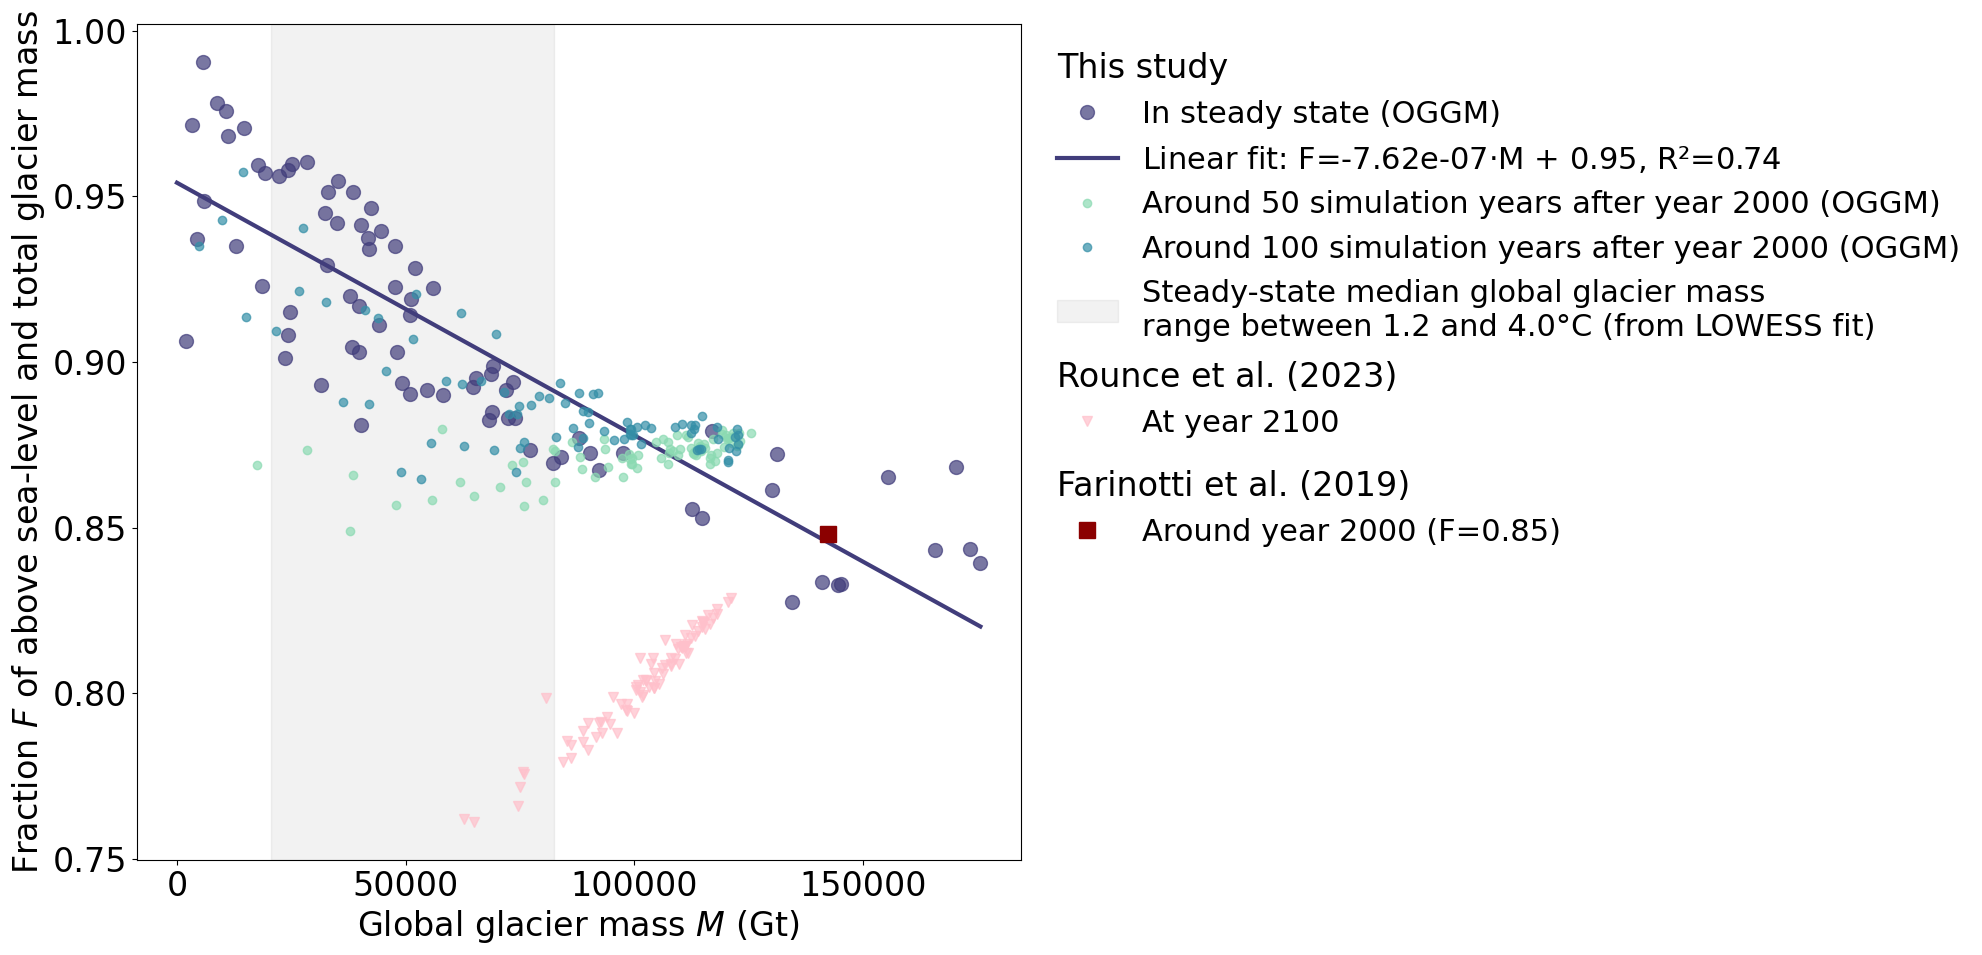

In [15]:
import scipy
import seaborn as sns

km3_to_gt = 900 * 1e-3# km3 -> Gt
m3_to_gt = 900 * 1e-12# m3 -> Gt


#### farinotti estimates 
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
y_farinotti = (vol_itmix_m3_reg- vol_bsl_itmix_m3)*m3_to_gt
x_farinotti = vol_itmix_m3_reg*m3_to_gt
print(rgi_reg,below_sl_ratio)

from moepy import lowess, eda
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 24})
j = 0
#fig, axs = plt.subplots(1,1,figsize=(20,10))
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, width_ratios=[7.3, 2.7])  # 70% for the plot, 30% for the legend

# Create the main plot area
ax = fig.add_subplot(gs[0])
#ax = axs


###################unfilled OGGM 
pd_slr_oggm_all_reg_ss_global['ratio_vol_asl_total'] = (pd_slr_oggm_all_reg_ss_global['volume_km3'] - pd_slr_oggm_all_reg_ss_global['volume_km3_bsl'])/pd_slr_oggm_all_reg_ss_global['volume_km3']
x = pd_slr_oggm_all_reg_ss_global.volume_km3*km3_to_gt#/1e9
y = pd_slr_oggm_all_reg_ss_global.ratio_vol_asl_total
ax.plot(x, y, 'o', ms=10,
         color=sns.color_palette('mako')[-5], label='In steady state (OGGM)', # , this study
         alpha = 0.7) # unfilled
res = scipy.stats.linregress(x,y)

print(res)
slope_unfilled, intercept_unfilled, r, p, se = res
r2 = np.square(r)
_x = np.arange(0,x.max(),1)
fit = _x*slope_unfilled + intercept_unfilled
fit[fit>1] = 1
fit[fit<0.7] = 0.7
ax.plot(_x, fit, color=sns.color_palette('mako')[-5],
         label=f'Linear fit: F={slope_unfilled:0.2e}'+r'$\cdot$M + ' + f'{intercept_unfilled.round(3):0.2f}, R²={r2.round(2)}',
         lw=3)


# get these estimates better from the upper plot ...
#df_quantiles['volume_km3'] = _x.round(0).astype(int)
#df_quantiles = df_quantiles.set_index('volume_km3')
#df_quantiles.rename(columns={'0.5':'ratio_ss_volume_asl_total'})
#df_quantiles.to_csv('OGGM_gmip3_unfilled_ratio_asl_total_volume.csv')




#### OGGM after 50/100 simulation years
color_o = {0:sns.color_palette('mako')[-1],1:sns.color_palette('mako')[-3]}
for j, year in enumerate([50,100]):
    pd_slr_oggm_reg_sel = pd_slr_oggm_all_global.loc[pd_slr_oggm_all_global.year == year] # pd_slr_oggm_reg.loc[pd_slr_oggm_reg.rgi_reg == rgi_reg]
    x = pd_slr_oggm_reg_sel.volume_km3.values*km3_to_gt
    y = (pd_slr_oggm_reg_sel.volume_km3.values - pd_slr_oggm_reg_sel.volume_km3_bsl.values)*km3_to_gt

    ax.plot(x,y/x, 'o', color=color_o[j], ms=6,
            label=f'Around {year} simulation years after year 2000 (OGGM)', #, this study)',
            alpha = 0.7, zorder=2) # unfilled -> too much info 


   

ax.axvspan(pd_vol_glob_2020_m3*0.15*m3_to_gt, pd_vol_glob_2020_m3*0.60*m3_to_gt, color='grey', alpha = 0.1,
            label='Steady-state median global glacier mass\nrange between 1.2 and 4.0°C (from LOWESS fit)')

print(slope_unfilled*(pd_vol_glob_2020_m3*0.15*m3_to_gt)+ intercept_unfilled)
print(slope_unfilled*(pd_vol_glob_2020_m3*0.60*m3_to_gt)+ intercept_unfilled)

    
##########################################
ds_rounce_rcps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-rcps.nc')
ds_rounce_ssps = xr.open_dataset('/home/www/lschuster/rounce_2023_data/Global_reg_allvns_50sets_2000_2100-ssps.nc')
_x_rounce_l = []
_ratio_rounce_l = []
for j,ds_rounce in enumerate([ds_rounce_rcps, ds_rounce_ssps]): 
    ds_rounce = ds_rounce.sum(dim='region', min_count=19).sel(year=2100)

    x_rounce = ds_rounce.reg_mass_annual *1e-12 ##/900 / 1e9  # kg /m3
    y_rounce = (ds_rounce.reg_mass_annual - ds_rounce.reg_mass_bsl_annual)*1e-12
    if j ==0: 
        ax.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'v',
                 ms=7,
                 label='At year 2100', #  (Rounce et al., 2023)
                 color='pink', alpha =0.7, zorder = 1)
    else:
        ax.plot(x_rounce.values.squeeze().flatten(),
                 y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten(), 'v', #label='Rounce et al., 2023\n(2020-2101)', 
                         color='pink', alpha =0.7, zorder = 1, ms=7)
    _x_rounce_l.append(x_rounce.values.squeeze().flatten())
    _ratio_rounce_l.append(y_rounce.values.squeeze().flatten()/x_rounce.values.squeeze().flatten())

# Perform linear fit with forced intercept at zero
_ratio = np.concatenate(_ratio_rounce_l)
_x_s = np.concatenate(_x_rounce_l)
slope = np.dot(_x_s[~np.isnan(_ratio)], 
               _ratio[~np.isnan(_ratio)]*_x_s[~np.isnan(_ratio)]) / np.dot(_x_s[~np.isnan(_ratio)], _x_s[~np.isnan(_ratio)])
_x = np.arange(0,_x_s[~np.isnan(_ratio)].max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#plt.plot(_x, fit/_x, color='blue', label=f'Linear Fit (Rounce et al., 2023):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)


#######################################

# Performing linear regression
#slope, intercept = np.polyfit(x, y, 1)
#_x = np.arange(0,x.max(),0.1)
# Perform linear fit with forced intercept at zero
slope = np.dot(x, y) / np.dot(x, x)
_x = np.arange(0,x.max(),1)
fit = _x*slope #+ #intercept
#fit[_x-fit<0] = 0 # below sea level should be above zero 
#fit[fit<0] = 0 # if above sea level is below zero -> set it equal tabove sea level should be above zero 

#ax.plot(_x, fit/_x, color='black', label=f'Linear Fit (only OGGM):\n'+r'V$_{asl}$'+f'= {slope:0.2f}*V', lw=3)

ax.set_xlabel(f'Global glacier mass $M$ (Gt)')
ax.set_ylabel(r'Fraction $F$ of above sea-level and total glacier mass')


#farinotti_intercept= (vol_itmix_m3_reg/1e9- vol_bsl_itmix_m3/1e9)-  vol_itmix_m3_reg/1e9*slope
#fit_f = _x*slope + farinotti_intercept
#fit_f[_x-fit_f<0] = _x[_x-fit_f<0] # if below sea level would get below zero, set it instead to zero 
#fit_f[fit_f<0] = 0  # above sea level should be above zero 

#ax.plot(_x, fit_f, color='blue',
#         label=f'Linear Fit, rescaled to\nFarinotti et al., 2019:\n'+r'V$_{asl}$'+f'={slope:0.2f}*V +{farinotti_intercept:0.1f}\n'+r'(and V$_{bsl}$≥0 & V$_{asl}$≥0)', lw=3)
reg_name = d_reg_num_name_sh[rgi_reg]
reg_name = reg_name.replace('\n',' ')
#ax.set_title('Globally')
#ax.axhline(1, color='grey', linestyle=':', label='ratio of 1', alpha = 0.5)

#ax.set_aspect('equal', adjustable='box')
#ax.text(0.98,0.02, 
#        f'Farinotti et al. (2019)\nabove sea-level ratio\nat inventory date: {(1-below_sl_ratio).round(2)}', 
#        va = 'bottom', ha='right',
#        transform=ax.transAxes)
# Set xticks and yticks to be equal
#max_value = max(max(x), max(y))
#max_value = int(np.ceil(max_value))
#ax.set_xticks(range(max_value + 1))
#ax.set_yticks(range(max_value + 1))



#### farinotti estimates 
vol_itmix_m3_reg = df_itmix['vol_itmix_m3'].sum()
vol_bsl_itmix_m3 = df_itmix['vol_bsl_itmix_m3'].sum()
below_sl_ratio = vol_bsl_itmix_m3/vol_itmix_m3_reg
y_farinotti = (vol_itmix_m3_reg- vol_bsl_itmix_m3)*m3_to_gt
x_farinotti = vol_itmix_m3_reg*m3_to_gt
print(rgi_reg,below_sl_ratio)

ax.plot(x_farinotti, y_farinotti/x_farinotti, 's', ms=12,color='darkred',
        label='Around year 2000 (F=0.85)') # FARINOTTI et al., 2019
#ax.axvline(x_farinotti, color = 'red', ls= '--',  label='Farinotti et al. (2019)\nat inventory date' )
#ax.axhline(y_farinotti/x_farinotti, color='darkred', lw=4, label=f'constant ratio of {(1-below_sl_ratio).round(2)}\n(Farinotti et al., 2019)')
    
#plt.plot(_x, _x*(1-below_sl_ratio)/_x, color='darkred', lw=4, label=f'constant ratio (Farinotti et al., 2019):\n'+r'V$_{asl}$' + f'={(1-below_sl_ratio).round(2)}' )
#ax.axvline(pd_vol_glob_m3/1e9, ls = '--', color='green')
# 40 85
ax.set_xticks([0,50000,100000,150000])

handles, labels = ax.get_legend_handles_labels()
#ax.legend(loc='upper left', fontsize=18, bbox_to_anchor=(1.02,1))

leg_this_study = ax.legend(handles[:5], labels[:5], title='This study', loc='upper left', 
                          fontsize=22, bbox_to_anchor=(1.01,1), frameon=False)
leg_rounce = ax.legend([handles[5]], [labels[5]], title='Rounce et al. (2023)', frameon=False,
                       loc='upper left', fontsize=22, bbox_to_anchor=(1.01,0.63))
leg_farinotti = ax.legend([handles[6]], [labels[6]], title='Farinotti et al. (2019)',loc='upper left', 
                          fontsize=22, bbox_to_anchor=(1.01,0.5), frameon=False)
leg_this_study._legend_box.align = "left"
leg_rounce._legend_box.align = "left"

leg_farinotti._legend_box.align = "left"
ax.add_artist(leg_this_study)
ax.add_artist(leg_rounce)
plt.tight_layout()
plt.savefig('figures/supplements/suppl_fig_S14.png')
plt.savefig('figures/supplements/suppl_fig_S14.pdf')

In [26]:
# save the fit for the notebook where the SL estimates are shown in a table (6_csv_tables_creation.ipynb)
import json
data = {
    "slope_unfilled": slope_unfilled, # this is in GT mass 
    "intercept_unfilled": intercept_unfilled # this is the fraction
}

# Save the variables to a JSON file
with open('../0_pre_post_processing/_intermediate_data/linear_fit_above_sea_level_fraction_vs_global_glacier_mass_gt_variables.json', 'w') as json_file:
    json.dump(data, json_file)

slope_unfilled, intercept_unfilled

(-7.622083219875667e-07, 0.9540695779131954)

In [25]:
### volume at farinotti et al. data
ratio_farinotti = 1- df_itmix.sum()['vol_bsl_itmix_m3']/df_itmix.sum()['vol_itmix_m3'] 
vol = df_itmix.sum()['vol_itmix_m3'] /1e9

ratio = slope_unfilled*vol + intercept_unfilled 
if ratio <0.7:
    ratio = 0.7
print(ratio, ratio_farinotti)

np.testing.assert_allclose(ratio,ratio_farinotti, rtol=0.02) #

0.8335213024434408 0.8480644826405563


In [ ]:
import seaborn as sns
pd_slr_oggm_reg_sel = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum().reset_index()

pd_slr_oggm_reg_sel['ratio'] = (pd_slr_oggm_reg_sel['volume_km3']- pd_slr_oggm_reg_sel['volume_km3_bsl']) / pd_slr_oggm_reg_sel['volume_km3']
fig,axs = plt.subplots(1,5,figsize=(35,10), sharey=True, sharex=True)
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==30], x='volume_km3', y= 'ratio', ax = axs[0]) # palette='coolwarm')
axs[0].set_title('after 30 simulation years')


sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==50], x='volume_km3', y= 'ratio', ax = axs[1]) # palette='coolwarm')
axs[1].set_title('after 50 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==100], x='volume_km3', y= 'ratio', ax = axs[2]) # palette='coolwarm')
axs[2].set_title('after 100 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==500], x='volume_km3', y= 'ratio', ax = axs[3]) # palette='coolwarm')
axs[3].set_title('after 500 simulation years')

axs[4].set_title('after 2000 simulation years')
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==2000], x='volume_km3', y= 'ratio', ax = axs[4]) # palette='coolwarm')
#plt.savefig('above_sl_ratio_evolution_gmip3_oggm.png')

In [ ]:
import seaborn as sns
pd_slr_oggm_reg_sel = pd_slr_oggm_all_reg.loc[pd_slr_oggm_all_reg.year <=2000].groupby(['gcm','period','ssp', 'year']).sum().reset_index()

pd_slr_oggm_reg_sel['ratio'] = (pd_slr_oggm_reg_sel['volume_km3']- pd_slr_oggm_reg_sel['volume_km3_bsl']) / pd_slr_oggm_reg_sel['volume_km3']
fig,axs = plt.subplots(1,4,figsize=(35,10), sharey=True, sharex=True)

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==80], x='volume_km3', y= 'ratio', ax = axs[0]) # palette='coolwarm')
axs[0].set_title('after 80 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==100], x='volume_km3', y= 'ratio', ax = axs[1]) # palette='coolwarm')
axs[1].set_title('after 100 simulation years')

sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==500], x='volume_km3', y= 'ratio', ax = axs[2]) # palette='coolwarm')
axs[2].set_title('after 500 simulation years')

axs[3].set_title('after 2000 simulation years')
sns.scatterplot(data=pd_slr_oggm_reg_sel.loc[pd_slr_oggm_reg_sel.year==2000], x='volume_km3', y= 'ratio', ax = axs[3]) # palette='coolwarm')
#plt.savefig('above_sl_ratio_evolution_gmip3_oggm.png')

### Some unsorted analysis...

*is the SLE mm ratio different ??*

In [20]:
convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5'], frac= 0.85) / convert_rel_ice_2020_mm_slr(pd_lowess_vol_gmt_glob.loc[3.0]['0.5'], frac=1)

0.85

- need to compute the volume at steady-state 
    - rel_ice_2020/100 * pd_vol_glob_2020_m3
- then compute volume difference 
    - vol_diff = pd_vol_glob_2020_m3 - rel_ice_2020/100 * pd_vol_glob_2020_
    
ρice = 900 kg m−3 , an ocean area of Aocean
= 3.625 × 108 km2 and a mean ocean density of ρocean = 1,028 kg m−3
(ref. 51 ), (2)

**around 6mm SL more for every tenth of a degree warming**

Text(0, 0.5, 'difference (lowess vs linear fit)\nrel. to 2020 volume')

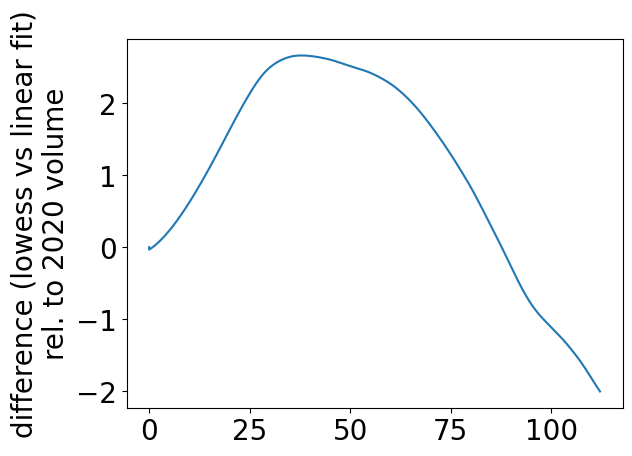

In [21]:
plt.plot(100*fit_lowess_x*1e9/pd_vol_glob_2020_m3, 100*(fit_lowess.values - fit_lowess_x*0.85)/(pd_vol_glob_2020_m3/1e9))
plt.ylabel('difference (lowess vs linear fit)\nrel. to 2020 volume')

-> more analysis on that in older github repository versions (before Oct 2024 clean-up ;-))